In [252]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import pickle

import torch.nn.functional as F

import matplotlib.pyplot as plt

In [253]:
device = torch.device("cpu")

In [254]:
with open('data/reset_splines.pkl', 'rb') as f:
    reset_splines = pickle.load(f)
with open('data/set_splines.pkl', 'rb') as f:
    set_splines = pickle.load(f)

In [255]:
# Hyperparameters
input_size = 28*28 
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.01

In [256]:
# Load MNIST dataset with downsampling
transform = transforms.Compose([
    transforms.Resize((28, 28)),  
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data/MNIST', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [257]:
class HardwareAwareOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, set_splines=None, reset_splines = None):
        defaults = dict(lr=lr)
        self.set_splines = set_splines
        self.reset_splines = reset_splines
        super(HardwareAwareOptimizer, self).__init__(params, defaults)

    def step(self):
        def map_weights_to_conductance(weight, min_weight, max_weight, min_conductance, max_conductance):
            # Linear interpolation from weight to conductance
            normalized_weights = (weight - min_weight) / (max_weight - min_weight)
            mapped_conductance = min_conductance + normalized_weights * (max_conductance - min_conductance)
            mapped_conductance = torch.clamp(mapped_conductance, min_conductance, max_conductance)
            return mapped_conductance
        
        def new_conductance(G0, grad):
            
            # G_pos = G0*1.05
            # G_neg = G0*(0.95)
            # Apply the splines based on gradient
            tau = 0.02
            # Masks for set, reset, and no change conditions
            set_mask = torch.ge(grad, tau)       # Apply set spline if grad >= tau
            reset_mask = torch.le(grad, -tau)    # Apply reset spline if grad <= -tau

            # Apply the set and reset splines
            G_pos = G0 * self.reset_splines['1 us'].ev(G0, -1.85)    # Set spline adjustment
            G_neg = G0 * self.set_splines['1 us'].ev(G0, 1.9) # Reset spline adjustment

            # Use torch.where to select G_pos, G_neg, or G0 based on conditions
            G_new = torch.where(set_mask, G_pos, torch.where(reset_mask, G_neg, G0))

            # G_new = torch.clamp(G_new, min=min_conductance, max=max_conductance)

            return G_new
        
        # def new_conductance(G0, grad):
            
        #     # G_pos = G0*1.05
        #     # G_neg = G0*(0.95)
        #     # Apply the splines based on gradient
        #     positive_mask = torch.le(grad, 0)  # Check for grad >= 0
        #     G_pos = G0 * (self.set_splines['1 us'].ev(G0, 2.5))
        #     G_neg = G0 * (self.reset_splines['1 us'].ev(G0, -2.5))
            
        #     # # Combine both positive and negative cases
        #     G_new = torch.where(positive_mask, G_pos, G_neg)
        #     return G_new

        def map_conductance_to_weights(conductance, min_conductance, max_conductance, min_weight, max_weight):
            # Reverse mapping from conductance to weight

            normalized_conductance = (conductance - min_conductance) / (max_conductance - min_conductance)
            mapped_weight = min_weight + normalized_conductance * (max_weight - min_weight)
            # mapped_weight = torch.clamp(mapped_weight, min_weight, max_weight)
            return mapped_weight

        def map_weights_to_conductance_sine(weight, min_weight, max_weight, min_conductance, max_conductance):
            mid_weight = (max_weight+min_weight)/2
            mid_conductance = (max_conductance + min_conductance)/2
            normalized_weight = (weight - mid_weight)/(max_weight-mid_weight)
            # normalized_conductance = 2/torch.pi * torch.arcsin(normalized_weight)
            
            # normalized_conductance = normalized_weight ** 3
            normalized_conductance = normalized_weight
            conductance = normalized_conductance * (max_conductance - mid_conductance) + mid_conductance
            # conductance = torch.clamp(conductance, min=min_conductance, max=max_conductance)
            return conductance
        
        def map_conductance_to_weights_sine(conductance, min_weight, max_weight, min_conductance, max_conductance):
            mid_weight = (max_weight+min_weight)/2
            mid_conductance = (max_conductance + min_conductance)/2
            normalized_conductance = (conductance - mid_conductance)/(max_conductance - mid_conductance)
            # normalized_weight = torch.sin(normalized_conductance * torch.pi/2)
            # normalized_weight = torch.sign(normalized_conductance) * torch.abs(normalized_conductance) ** (1/3)
            normalized_weight = normalized_conductance
            weight = normalized_weight*(max_weight - mid_weight) + mid_weight
            # weight = weight.clamp(min=min_weight, max=max_weight)
            return weight



        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                min_weight, max_weight = -1.5, 1.5
                min_conductance, max_conductance = 5e-7, 3e-6
                
                # Get the current weights and gradients
                weight, grad = p.data, p.grad.data

                # 1. Map weights to conductance values
                G0 = map_weights_to_conductance_sine(
                    weight=weight,
                    min_weight=min_weight,
                    max_weight=max_weight,
                    min_conductance=min_conductance,
                    max_conductance=max_conductance
                )

                # 2. Modify conductance using spline function based on the gradient
                G_new = new_conductance(G0=G0, grad=grad)

                # 3. Map the new conductance values back to weights
                new_weight = map_conductance_to_weights_sine(
                    conductance=G_new,
                    min_conductance=min_conductance,
                    max_conductance=max_conductance,
                    min_weight=min_weight,
                    max_weight=max_weight
                )
                
                # Update the weights in the optimizer
                p.data.copy_(new_weight)  # In-place update of the weights


In [258]:
# # Define MLP model with no hidden layers
# class SimpleMLP(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(SimpleMLP, self).__init__()
#         self.fc = nn.Linear(input_size, num_classes)
#         self.softmax = nn.Softmax(dim=1)
#         # Initialize weights
#         self.init_weights()

#     def init_weights(self):
#         for layer in self.children():
#             if isinstance(layer, (nn.Linear, nn.Conv2d)):
#                 nn.init.xavier_uniform_(layer.weight)
#                 nn.init.zeros_(layer.bias)
    
#     def forward(self, x):
#         x = x.view(-1, input_size)  # Flatten the input
#         x = self.fc(x)
#         x = self.softmax(x)
#         return x
    

# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(SimpleCNN, self).__init__()
        
#         # Define the convolutional layers
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)  # First convolution layer
#         self.conv2 = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=1, padding=1)  # Second convolution layer
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling layer

#         # Fully connected layer
#         self.fc1 = nn.Linear( 2 * 7 * 7, num_classes)  # Adjust 7x7 based on the input size and pooling
#         # Initialize weights
#         self.init_weights()

#     def init_weights(self):
#         for layer in self.children():
#             if isinstance(layer, (nn.Linear, nn.Conv2d)):
#                 nn.init.xavier_uniform_(layer.weight)
#                 nn.init.zeros_(layer.bias)

#     def forward(self, x):
#         # Pass through convolutional layers with ReLU activation and pooling
#         x = self.pool(F.leaky_relu(self.conv1(x)))
#         x = self.pool(F.leaky_relu(self.conv2(x)))

#         # Flatten the tensor for the fully connected layer
#         x = x.view(x.size(0), -1)  # Flatten the tensor


#         # Pass through the fully connected layer
#         x = self.fc1(x)
        
#         # x = F.softmax(x, dim=1)
        
        
#         return x

In [259]:

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.05): 
        super(SimpleCNN, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)  # First convolution layer
        self.bn1 = nn.BatchNorm2d(4)  # Batch normalization
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=1, padding=1)  # Second convolution layer
        self.bn2 = nn.BatchNorm2d(2)  # Batch normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling layer
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer with specified probability

        # Fully connected layer
        self.fc1 = nn.Linear(2 * 7 * 7, num_classes)  # Adjust 7x7 based on the input size and pooling

        
        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for layer in self.children():
            if isinstance(layer, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        # Pass through convolutional layers with ReLU activation and pooling
        x = self.pool(F.elu(self.bn1(self.conv1(x))))  # Batch normalization after conv1
        x = self.pool(F.elu(self.bn2(self.conv2(x))))  # Batch normalization after conv2

        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        # Apply dropout before the fully connected layer
        # x = self.dropout(x)  # Apply dropout

        # Pass through the fully connected layer
        x = self.fc1(x)
        # x = F.softmax(x, dim=1)

        
        
        return x

In [260]:
# Initialize model, loss, and optimizer
# model = SimpleMLP(input_size, num_classes).to(device)
model = SimpleCNN(num_classes).to(device)
# model_dicts = []
best_loss = 1e9
criterion = nn.CrossEntropyLoss()
optimizer = HardwareAwareOptimizer(model.parameters(), lr=0.01, set_splines=set_splines, reset_splines=reset_splines)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    correct, total = 0, 0
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/(50000/batch_size):.4f}, Accuracy = {correct/total:.4f}")
    # if loss<best_loss:
    #     best_loss = loss
    # model_dicts.append(model.state_dict())


Total number of parameters: 1116
Epoch [1/20], Loss: 1.3033, Accuracy = 0.8255
Epoch [2/20], Loss: 1.2499, Accuracy = 0.7483
Epoch [3/20], Loss: 1.2104, Accuracy = 0.7199
Epoch [4/20], Loss: 1.2024, Accuracy = 0.5886
Epoch [5/20], Loss: 1.2290, Accuracy = 0.6796
Epoch [6/20], Loss: 1.2342, Accuracy = 0.7275
Epoch [7/20], Loss: 1.2274, Accuracy = 0.6682
Epoch [8/20], Loss: 1.2155, Accuracy = 0.7669
Epoch [9/20], Loss: 1.2141, Accuracy = 0.5916
Epoch [10/20], Loss: 1.2415, Accuracy = 0.7636
Epoch [11/20], Loss: 1.2246, Accuracy = 0.7473
Epoch [12/20], Loss: 1.2133, Accuracy = 0.5994
Epoch [13/20], Loss: 1.2552, Accuracy = 0.7501
Epoch [14/20], Loss: 1.2456, Accuracy = 0.6659
Epoch [15/20], Loss: 1.1743, Accuracy = 0.7107
Epoch [16/20], Loss: 1.2110, Accuracy = 0.7434
Epoch [17/20], Loss: 1.2561, Accuracy = 0.6655
Epoch [18/20], Loss: 1.2424, Accuracy = 0.4050
Epoch [19/20], Loss: 1.2124, Accuracy = 0.7900
Epoch [20/20], Loss: 1.2711, Accuracy = 0.7204


In [261]:
# curr_model = SimpleCNN(num_classes)
# curr_model.load_state_dict(model_dicts[2])
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f"Test Accuracy of the model on the 10,000 test images: {100 * correct / total:.2f}%")

Test Accuracy of the model on the 10,000 test images: 72.63%


In [262]:
# torch.save(model.state_dict(), "data/cnn_on_mnist_HAT.pt")

In [263]:

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 1116


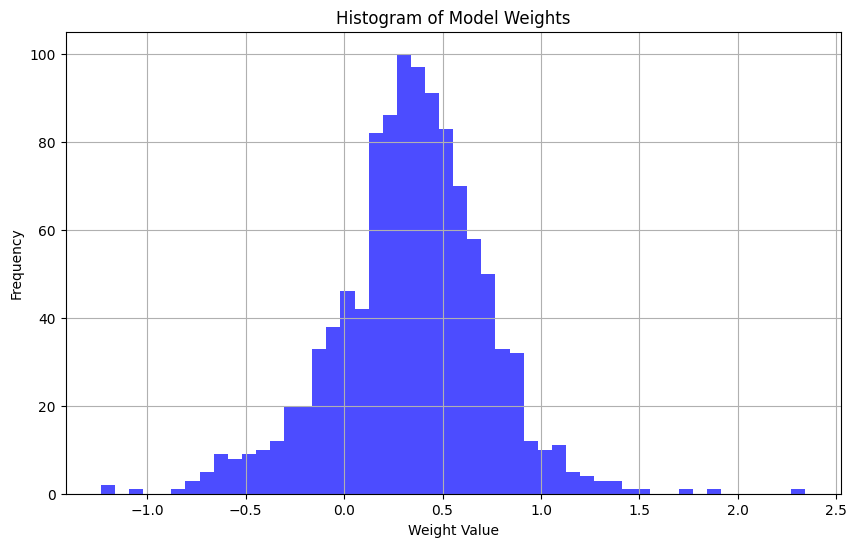

In [264]:
temp_model = SimpleCNN(num_classes).to(device)
def plot_model_weights_histogram(model):
    # Collect all weights in the model
    all_weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:  # only take weights, ignore biases
            all_weights.extend(param.data.cpu().numpy().flatten())
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(all_weights, bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Model Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_model_weights_histogram(model=model)

In [265]:
# torch.save(model.state_dict(), "data/cnn_with_leakyRelu.pth")

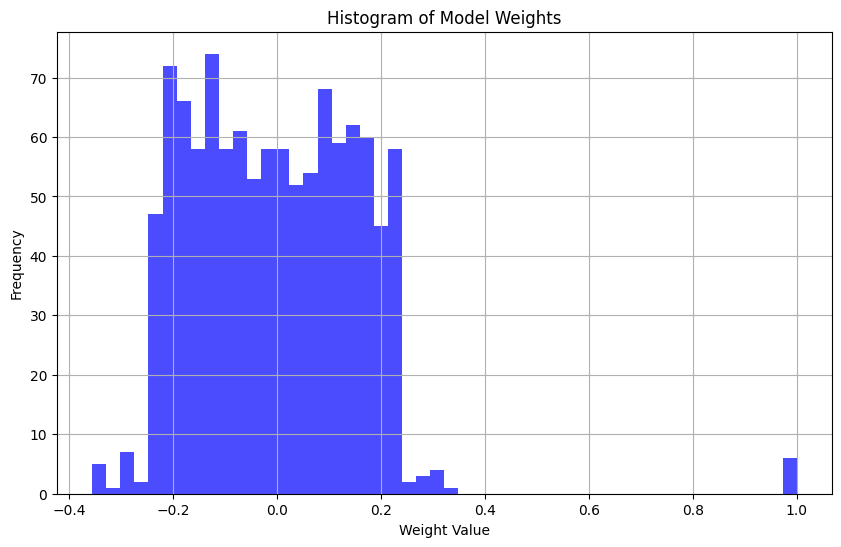

In [266]:


plot_model_weights_histogram(model=temp_model)